In [ ]:
### two stage architecture evaluation

In [ ]:
### Exp 2: classifier PD (64, 1e-4, 30); classifier MP (32, 1e-3, 30); classifier FP (32, 1e-4, 20)

Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]
<ipython-input-2-c5a47238f324>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Total samples: 2702
Samples classified as HC: 1838
Precision: 0.9681
Recall: 0.9678
F1 Score: 0.9679
MCC: 0.9363


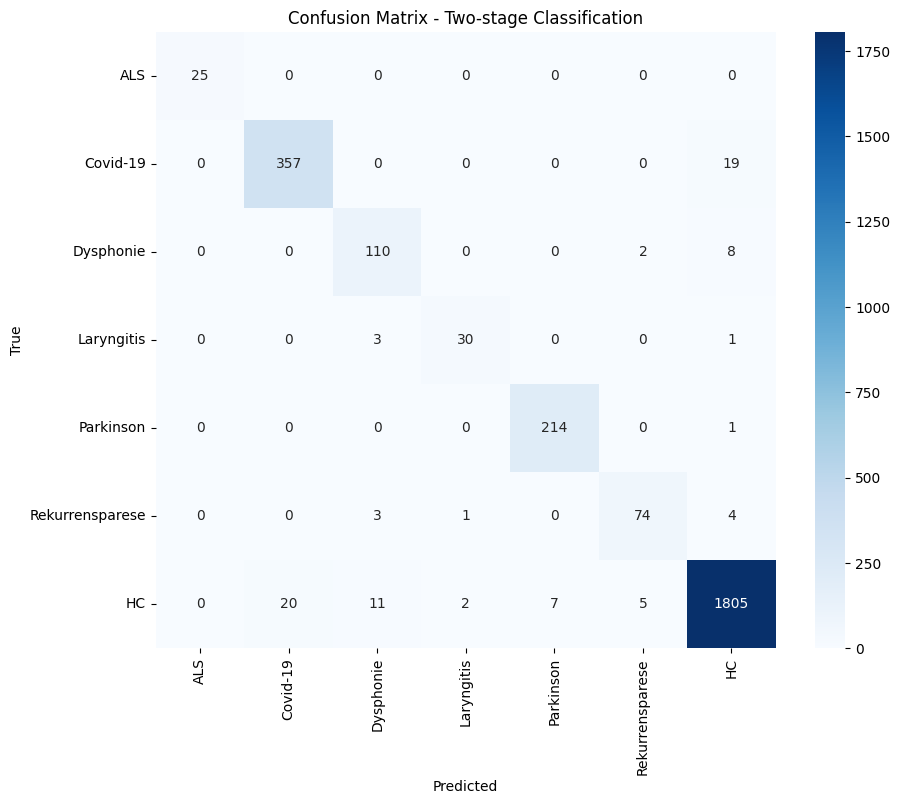

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5: 
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()


In [ ]:
### Exp 3.1 Resampling Augmentation based two stage architecture

In [ ]:
### classifier PD (64, 1e-4, 20); classifier MP (32, 1e-3, 30); classifier FP (64, 1e-3, 30)

Using device: cuda


<ipython-input-3-c5a47238f324>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Total samples: 2702
Samples classified as HC: 1875
Precision: 0.9671
Recall: 0.9671
F1 Score: 0.9666
MCC: 0.9339


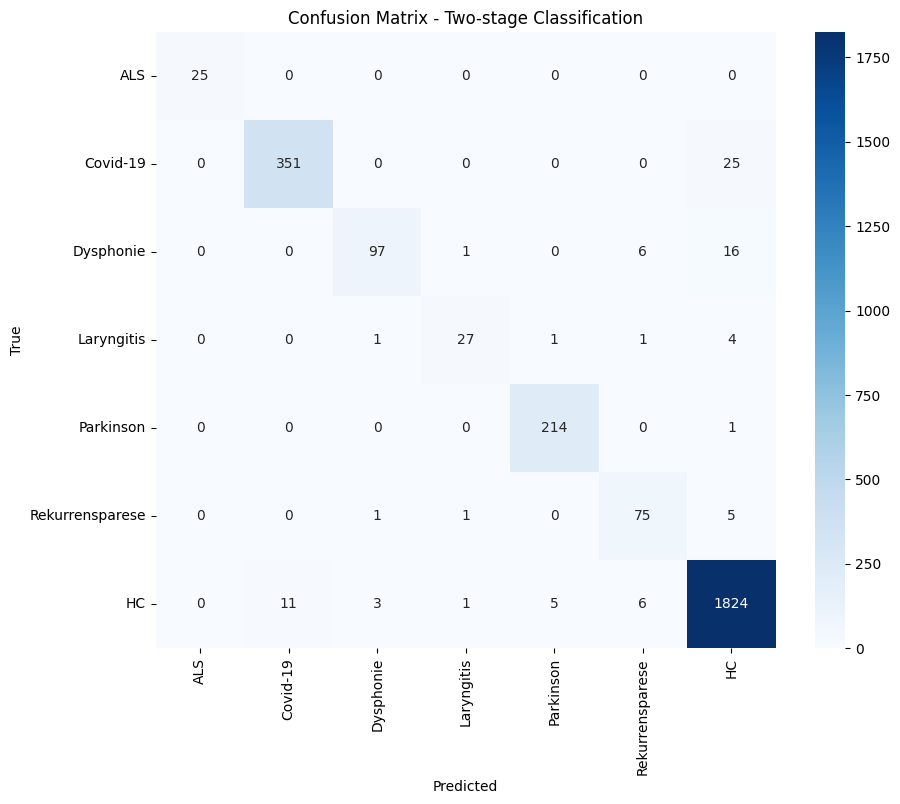

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx]) 
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5:
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()


In [ ]:
### Exp 3.2 Timewarp based two stage architecture

In [ ]:
### classifier PD (64, 1e-4, 30); classifier MP (64, 1e-3, 20); classifier FP (64, 1e-3, 30)

Using device: cuda


<ipython-input-4-c5a47238f324>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Total samples: 2702
Samples classified as HC: 1880
Precision: 0.9762
Recall: 0.9763
F1 Score: 0.9761
MCC: 0.9525


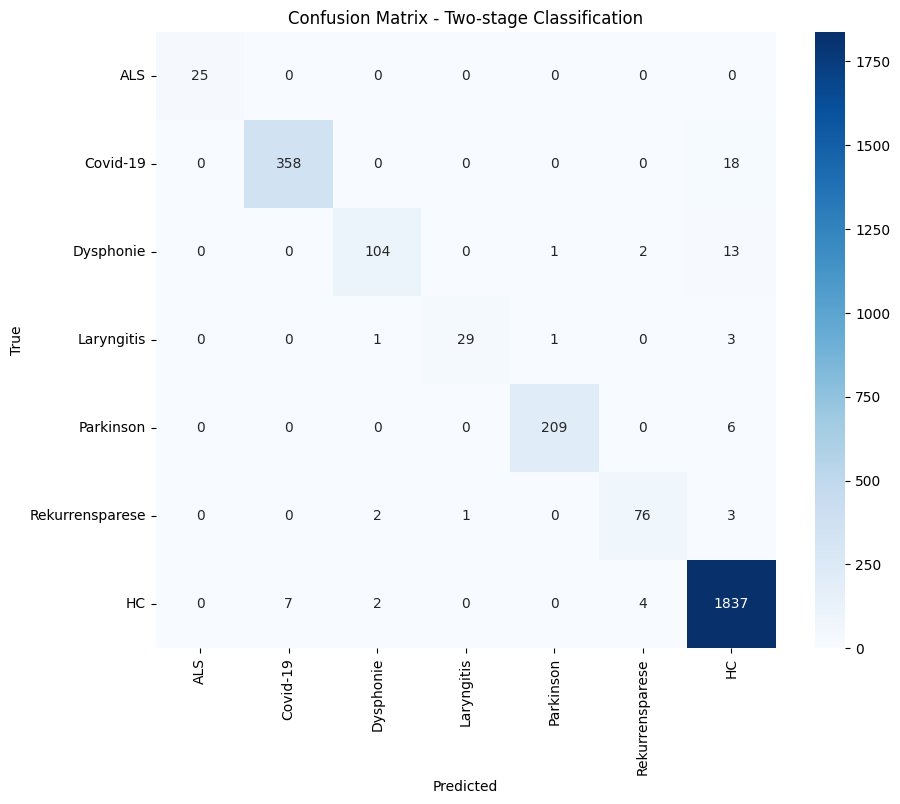

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from torchvision.models import ResNet50_Weights

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Class Mapping
group_classes = {"MC": 0, "MP": 1, "FC": 2, "FP": 3}
disease_classes = {
    "ALS": 0,
    "Covid-19": 1,
    "Dysphonie": 2,
    "Laryngitis": 3,
    "Parkinson": 4,
    "Rekurrensparese": 5,
    "HC": 6
}

# Class ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

class MelDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0) 
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel, label

def load_model(model_path, num_classes):
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

def get_test_loader(test_files, test_labels, batch_size=32):
    test_dataset = MelDataset(test_files, test_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Group Classifier
group_model = load_model("/content/MA/final_group_classifier.pth", num_classes=4)

# Load MP and FP Classifier
mp_model = load_model("/content/MA/best_resnet50_MP_model.pth", num_classes=6)
fp_model = load_model("/content/MA/best_resnet50_FP_model.pth", num_classes=6)

def get_file_paths_and_labels(df, base_dir):
    files, labels = [], []
    for _, row in df.iterrows():
        relative_path = row['Full_Path']
        pathology = row['Pathology']
        full_path = os.path.join(base_dir, relative_path.replace('\\', '/'))
        if os.path.exists(full_path) and pathology in disease_classes:
            files.append(full_path)
            labels.append(disease_classes[pathology])
        else:
            print(f"Warning: File {full_path} does not exist or invalid pathology.")
    return files, labels

test_set_path = os.path.join("/content/MA", "test_set.xlsx")
test_df = pd.read_excel(test_set_path)
test_files, test_labels = get_file_paths_and_labels(test_df, "/content/MA")

test_loader = get_test_loader(test_files, test_labels)

y_true, y_pred = [], []

total_samples, mc_fc_count = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.numpy()
        if len(inputs.shape) == 5:  
            inputs = inputs.squeeze(2)
        group_outputs = group_model(inputs)
        group_preds = torch.argmax(group_outputs, axis=1).cpu().numpy()

        for i, group_pred in enumerate(group_preds):
            if group_pred in [group_classes["MC"], group_classes["FC"]]:
                y_true.append(labels[i])
                y_pred.append(disease_classes["HC"])
                mc_fc_count += 1
            elif group_pred == group_classes["MP"]:
                mp_output = mp_model(inputs[i].unsqueeze(0))
                mp_pred = torch.argmax(mp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(mp_pred)
            elif group_pred == group_classes["FP"]:
                fp_output = fp_model(inputs[i].unsqueeze(0))
                fp_pred = torch.argmax(fp_output, axis=1).cpu().item()
                y_true.append(labels[i])
                y_pred.append(fp_pred)

print(f"Total samples: {len(test_labels)}")
print(f"Samples classified as HC: {mc_fc_count}")

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=disease_classes.keys(),
            yticklabels=disease_classes.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Two-stage Classification")
plt.show()
